# Deep Learning Beyond the Basics

## Classifying images with CNN

In [1]:
# Make sure to have the dataset in place, downloaded from:
# http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset
# 
# On linux systems:
#! wget -q http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip
#! unzip -q GTSRB_Final_Training_Images.zip

In [2]:
import keras

/home/lm/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
N_CLASSES = 43
RESIZED_IMAGE = (32, 32)

In [4]:
import matplotlib.pyplot as plt
import glob
from skimage.color import rgb2lab
from skimage.transform import resize
from collections import namedtuple
import numpy as np
np.random.seed(101)
%matplotlib inline

Dataset = namedtuple('Dataset', ['X', 'y'])

def to_tf_format(imgs):
    return np.stack([img[:, :, np.newaxis] for img in imgs], axis=0).astype(np.float32)

def read_dataset_ppm(rootpath, n_labels, resize_to):
    images = []
    labels = []
  
    for c in range(n_labels):
        full_path = rootpath + '/' + format(c, '05d') + '/'
        for img_name in glob.glob(full_path + "*.ppm"):

            img = plt.imread(img_name).astype(np.float32)
            img = rgb2lab(img / 255.0)[:,:,0]
            if resize_to:
                img = resize(img, resize_to, mode='reflect', anti_aliasing=True)

            label = np.zeros((n_labels, ), dtype=np.float32)
            label[c] = 1.0

            images.append(img.astype(np.float32))
            labels.append(label)

    return Dataset(X = to_tf_format(images).astype(np.float32),
                 y = np.matrix(labels).astype(np.float32))

dataset = read_dataset_ppm('GTSRB/Final_Training/Images', N_CLASSES, RESIZED_IMAGE)
print(dataset.X.shape)
print(dataset.y.shape)

(39209, 32, 32, 1)
(39209, 43)


Label: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


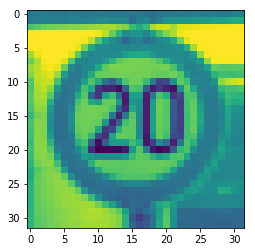

In [9]:
plt.imshow(dataset.X[0, :, :, :].reshape(RESIZED_IMAGE))
print("Label:", dataset.y[0, :])

Label: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


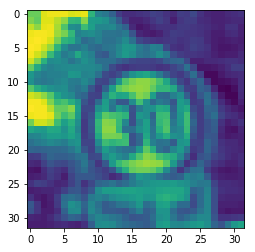

In [6]:
plt.imshow(dataset.X[1000, :, :, :].reshape(RESIZED_IMAGE))
print("Label:", dataset.y[1000, :])

In [7]:
from sklearn.model_selection import train_test_split
idx_train, idx_test = train_test_split(range(dataset.X.shape[0]), test_size=0.25, random_state=101)
X_train = dataset.X[idx_train, :, :, :]
X_test = dataset.X[idx_test, :, :, :]
y_train = dataset.y[idx_train, :]
y_test = dataset.y[idx_test, :]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(29406, 32, 32, 1)
(29406, 43)
(9803, 32, 32, 1)
(9803, 43)


In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD
from keras import backend as K
K.set_image_data_format('channels_last')

def cnn_model_1():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), 
                     padding='same',
                     input_shape=(RESIZED_IMAGE[0], RESIZED_IMAGE[1], 1),
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(N_CLASSES, activation='softmax'))
    return model


cnn = cnn_model_1()
cnn.compile(loss='categorical_crossentropy',
            optimizer=SGD(lr=0.001, decay=1e-6),
            metrics=['accuracy'])

cnn.fit(X_train, 
        y_train,
        batch_size=32,
        epochs=10,
        validation_data=(X_test, y_test))

Train on 29406 samples, validate on 9803 samples
Epoch 1/10
29406/29406 [==============================] - 26s 889us/step - loss: 1.7787 - acc: 0.6613 - val_loss: 0.7206 - val_acc: 0.8520
Epoch 2/10
29406/29406 [==============================] - 7s 229us/step - loss: 0.4512 - acc: 0.9025 - val_loss: 0.4357 - val_acc: 0.8975
Epoch 3/10
29406/29406 [==============================] - 7s 232us/step - loss: 0.2933 - acc: 0.9384 - val_loss: 0.3122 - val_acc: 0.9310
Epoch 4/10
29406/29406 [==============================] - 7s 224us/step - loss: 0.2102 - acc: 0.9577 - val_loss: 0.2814 - val_acc: 0.9359
Epoch 5/10
29406/29406 [==============================] - 7s 225us/step - loss: 0.1612 - acc: 0.9664 - val_loss: 0.2333 - val_acc: 0.9503
Epoch 6/10
29406/29406 [==============================] - 7s 225us/step - loss: 0.1288 - acc: 0.9734 - val_loss: 0.2386 - val_acc: 0.9486
Epoch 7/10
29406/29406 [==============================] - 7s 225us/step - loss: 0.1107 - acc: 0.9793 - val_loss: 0.2177 - 

             precision    recall  f1-score   support

          0       0.89      0.75      0.81        67
          1       0.99      0.77      0.87       539
          2       0.87      0.97      0.91       558
          3       0.88      0.93      0.91       364
          4       0.85      0.98      0.91       487
          5       0.92      0.90      0.91       479
          6       0.97      0.99      0.98       105
          7       0.97      0.96      0.97       364
          8       0.96      0.96      0.96       340
          9       0.99      0.97      0.98       384
         10       0.97      0.97      0.97       513
         11       0.93      0.97      0.95       334
         12       0.97      0.98      0.98       545
         13       1.00      0.99      0.99       537
         14       0.99      1.00      0.99       213
         15       0.98      0.99      0.98       164
         16       0.99      1.00      0.99        98
         17       0.99      0.98      0.99   

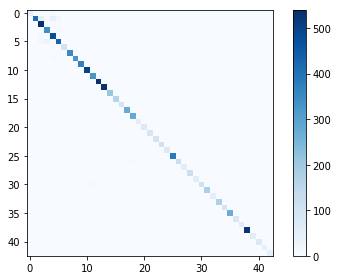

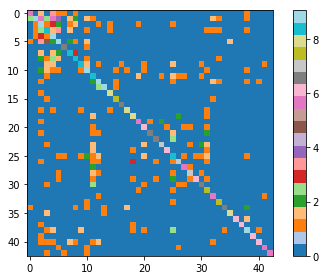

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

def test_and_plot(model, X, y):
  y_pred = cnn.predict(X)
  y_pred_softmax = np.argmax(y_pred, axis=1).astype(np.int32)
  y_test_softmax = np.argmax(y, axis=1).astype(np.int32).A1


  print(classification_report(y_test_softmax, y_pred_softmax))

  cm = confusion_matrix(y_test_softmax, y_pred_softmax)

  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.colorbar()
  plt.tight_layout()
  plt.show()

  # And the log2 version, to enphasize the misclassifications
  plt.imshow(np.log2(cm + 1), interpolation='nearest', cmap=plt.get_cmap("tab20"))
  plt.colorbar()
  plt.tight_layout()
  plt.show()


test_and_plot(cnn, X_test, y_test)


In [10]:
from keras.layers.core import Dropout
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam
from keras.layers import BatchNormalization

def cnn_model_2():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), 
                     padding='same',
                     input_shape=(RESIZED_IMAGE[0], RESIZED_IMAGE[1], 1),
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), 
                     padding='same',
                     input_shape=(RESIZED_IMAGE[0], RESIZED_IMAGE[1], 1),
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(N_CLASSES, activation='softmax'))
    return model


cnn = cnn_model_2()
cnn.compile(loss='categorical_crossentropy',
            optimizer=Adam(lr=0.001, decay=1e-6),
            metrics=['accuracy'])

cnn.fit(X_train, 
        y_train,
        batch_size=32,
        epochs=10,
        validation_data=(X_test, y_test))

Train on 29406 samples, validate on 9803 samples
Epoch 1/10
29406/29406 [==============================] - 24s 812us/step - loss: 0.6752 - acc: 0.8232 - val_loss: 0.1909 - val_acc: 0.9540
Epoch 2/10
29406/29406 [==============================] - 24s 802us/step - loss: 0.1714 - acc: 0.9511 - val_loss: 0.0825 - val_acc: 0.9776
Epoch 3/10
29406/29406 [==============================] - 24s 828us/step - loss: 0.0991 - acc: 0.9697 - val_loss: 0.0591 - val_acc: 0.9831
Epoch 4/10
29406/29406 [==============================] - 26s 873us/step - loss: 0.0673 - acc: 0.9782 - val_loss: 0.0408 - val_acc: 0.9895
Epoch 5/10
29406/29406 [==============================] - 26s 894us/step - loss: 0.0699 - acc: 0.9783 - val_loss: 0.0794 - val_acc: 0.9742
Epoch 6/10
29406/29406 [==============================] - 30s 1ms/step - loss: 0.0575 - acc: 0.9822 - val_loss: 0.0436 - val_acc: 0.9882
Epoch 7/10
29406/29406 [==============================] - 32s 1ms/step - loss: 0.0565 - acc: 0.9819 - val_loss: 0.0329 

             precision    recall  f1-score   support

          0       1.00      0.96      0.98        67
          1       0.98      0.99      0.98       539
          2       0.96      0.99      0.98       558
          3       1.00      0.99      0.99       364
          4       0.99      1.00      0.99       487
          5       0.99      0.96      0.98       479
          6       1.00      0.99      1.00       105
          7       0.99      0.99      0.99       364
          8       0.99      0.97      0.98       340
          9       1.00      0.99      1.00       384
         10       1.00      1.00      1.00       513
         11       0.98      0.99      0.99       334
         12       1.00      1.00      1.00       545
         13       1.00      1.00      1.00       537
         14       1.00      1.00      1.00       213
         15       1.00      1.00      1.00       164
         16       1.00      1.00      1.00        98
         17       1.00      1.00      1.00   

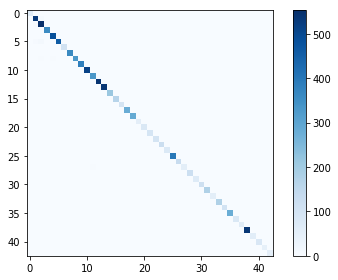

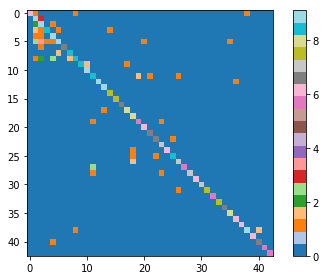

In [11]:
test_and_plot(cnn, X_test, y_test)

## Using pre-trained models

In [12]:
# Make sure to have the dataset in place, downloaded from:
# http://www.vision.caltech.edu/Image_Datasets/Caltech101/
# 
# On linux systems:
#! wget -q http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
#! tar -xf 101_ObjectCategories.tar.gz

In [13]:
import keras

In [14]:
from keras.applications.inception_v3 import InceptionV3,\
                     preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
model = InceptionV3(weights='imagenet')

In [16]:
def predict_top_3(model, img_path):
  img = image.load_img(img_path, target_size=(299, 299))
  plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model.predict(x)
  print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n04507155', 'umbrella', 0.88384426), ('n04254680', 'soccer_ball', 0.07257444), ('n03888257', 'parachute', 0.0128492275)]


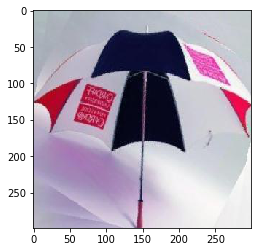

In [17]:
predict_top_3(model, "101_ObjectCategories/umbrella/image_0001.jpg")

Predicted: [('n02704792', 'amphibian', 0.20315959), ('n04389033', 'tank', 0.07382987), ('n04252077', 'snowmobile', 0.055827927)]


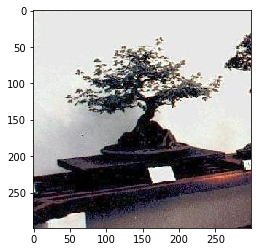

In [18]:
predict_top_3(model, "101_ObjectCategories/bonsai/image_0001.jpg")

In [19]:
print([l.name for l in model.layers])

['input_1', 'conv2d_4', 'batch_normalization_4', 'activation_1', 'conv2d_5', 'batch_normalization_5', 'activation_2', 'conv2d_6', 'batch_normalization_6', 'activation_3', 'max_pooling2d_2', 'conv2d_7', 'batch_normalization_7', 'activation_4', 'conv2d_8', 'batch_normalization_8', 'activation_5', 'max_pooling2d_3', 'conv2d_12', 'batch_normalization_12', 'activation_9', 'conv2d_10', 'conv2d_13', 'batch_normalization_10', 'batch_normalization_13', 'activation_7', 'activation_10', 'average_pooling2d_1', 'conv2d_9', 'conv2d_11', 'conv2d_14', 'conv2d_15', 'batch_normalization_9', 'batch_normalization_11', 'batch_normalization_14', 'batch_normalization_15', 'activation_6', 'activation_8', 'activation_11', 'activation_12', 'mixed0', 'conv2d_19', 'batch_normalization_19', 'activation_16', 'conv2d_17', 'conv2d_20', 'batch_normalization_17', 'batch_normalization_20', 'activation_14', 'activation_17', 'average_pooling2d_2', 'conv2d_16', 'conv2d_18', 'conv2d_21', 'conv2d_22', 'batch_normalization_16

In [20]:
from keras.models import Model
feat_model = Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)

def extract_features(feat_model, img_path):
  img = image.load_img(img_path, target_size=(299, 299))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  return feat_model.predict(x)


f = extract_features(feat_model, "101_ObjectCategories/bonsai/image_0001.jpg")
print(f.shape)
print(f)

(1, 2048)
[[0.12340273 0.08338219 0.7935957  ... 0.48702148 0.5086972  0.3401563 ]]


## Working with temporal sequences

In [21]:
import keras

In [22]:
from keras.datasets import imdb
(data_train, y_train), (data_test, y_test) = imdb.load_data(num_words=25000)

17465344/17464789 [==============================] - 15s 1us/step


In [23]:
print(data_train.shape)
print(data_train[0])
print(len(data_train[0]))

(25000,)
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
218


In [24]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(data_train, maxlen=100)
X_test = pad_sequences(data_test, maxlen=100)

In [25]:
print(X_train[0])
print(X_train[0].shape)

[ 1415    33     6    22    12   215    28    77    52     5    14   407
    16    82 10311     8     4   107   117  5952    15   256     4     2
     7  3766     5   723    36    71    43   530   476    26   400   317
    46     7     4 12118  1029    13   104    88     4   381    15   297
    98    32  2071    56    26   141     6   194  7486    18     4   226
    22    21   134   476    26   480     5   144    30  5535    18    51
    36    28   224    92    25   104     4   226    65    16    38  1334
    88    12    16   283     5    16  4472   113   103    32    15    16
  5345    19   178    32]
(100,)


In [26]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam

model = Sequential()
model.add(Embedding(25000, 256, input_length=100))
model.add(LSTM(256, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

In [27]:
model.fit(X_train, 
          y_train,
          batch_size=64,
          epochs=10,
          validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 108s 4ms/step - loss: 0.4846 - acc: 0.7654 - val_loss: 0.4591 - val_acc: 0.7860
Epoch 2/10
25000/25000 [==============================] - 142s 6ms/step - loss: 0.3375 - acc: 0.8602 - val_loss: 0.4010 - val_acc: 0.8214
Epoch 3/10
25000/25000 [==============================] - 146s 6ms/step - loss: 0.2706 - acc: 0.8946 - val_loss: 0.3845 - val_acc: 0.8437
Epoch 4/10
25000/25000 [==============================] - 146s 6ms/step - loss: 0.1876 - acc: 0.9293 - val_loss: 0.4126 - val_acc: 0.8364
Epoch 5/10
25000/25000 [==============================] - 167s 7ms/step - loss: 0.1475 - acc: 0.9464 - val_loss: 0.5607 - val_acc: 0.8312
Epoch 6/10
25000/25000 [==============================] - 146s 6ms/step - loss: 0.1059 - acc: 0.9620 - val_loss: 0.5656 - val_acc: 0.8337
Epoch 7/10
25000/25000 [==============================] - 171s 7ms/step - loss: 0.0781 - acc: 0.9732 - val_loss: 0.6295 - 